In [14]:
import numpy as np
import pandas as pd
import scipy.stats as st
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import io
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials
import os
from scipy.stats import bootstrap

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
#условие размера графиков
sns.set(rc={'figure.figsize':(12,4)}, style="whitegrid")

In [ ]:
3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv 
(заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [3]:
tables_name = ['project_2_active_studs', 'projec_2_checks', 'project_2_group_add', 'project_2_groups'] #названия датафреймов на моем диске

In [15]:
list_df = [] #создаем список чтобы туда добавлялись датафреймы

In [16]:

# Specify path to your file with credentials
path_to_credential = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-chernov-36/Data_fp/my-final-project-403511-32a5169a03fd.json' 

# Specify name of table in google sheets

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credential, scope)

gs = gspread.authorize(credentials)
def download_dataset(dataset): #создаем функцию для прочитывания датасетов из гугл таблиц и добавления датафрейма в список
    work_sheet = gs.open(dataset)

    # Select 1st sheet
    sheet1 = work_sheet.sheet1

    # Get data in python lists format
    data = sheet1.get_all_values()

    # Get header from data
    headers = data.pop(0)

    # Create df
    df = pd.DataFrame(data, columns=headers)
    
    #добавляем датафреймы в список
    list_df.append(df)
    
    return

In [17]:
download_dataset('project_2_active_studs') #вызываем функцию, добавляя active_studs в список

In [18]:
active_studs = list_df[-1] #присваиваем имя датафрейму из последнего добавленного

In [19]:
download_dataset('projec_2_checks') 

In [20]:
checks = list_df[-1]

In [21]:
download_dataset('project_2_group_add')

In [22]:
groups_add = list_df[-1]

In [23]:
download_dataset('project_2_groups')

In [24]:
groups = list_df[-1]

In [25]:
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [15]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [16]:
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [17]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [ ]:
#Вопросы
#1)На какие метрики Вы смотрите в ходе анализа и почему?
#2)Имеются ли различия в показателях и с чем они могут быть связаны?
#3)Являются ли эти различия статистически значимыми?
#4)Стоит ли запускать новую механику на всех пользователей?

In [ ]:
#Ответы:
#1)Средняя сумма оплаты (checks.rev)  Потому что чем больше сумма оплаты , тем успешнее новая механика оплаты.

In [ ]:
#Нулевая гипотеза (H0): Разницы между средней суммой в тестовой и контрольной группе нет
#Альтернативная гипотеза (H1): Разница между средней суммой  в тестовой и контрольной группе есть

In [18]:
#проверка на пропущенные значения
for i, df in enumerate(list_df):
    if df.isna().values.any():
        print(f"Датафрейм {i+1} содержит пропущенные значения.")
    else:
        print(f"Датафрейм {i+1} не содержит пропущенных значений.")

Датафрейм 1 не содержит пропущенных значений.
Датафрейм 2 не содержит пропущенных значений.
Датафрейм 3 не содержит пропущенных значений.
Датафрейм 4 не содержит пропущенных значений.


In [19]:
#проверка на дублкаты 
for i, df in enumerate(list_df):
    if df.duplicated().values.any():
        print(f"Датафрейм {i+1} содержит дубликаты.")
    else:
        print(f"Датафрейм {i+1} не содержит дубликатов.")

Датафрейм 1 не содержит дубликатов.
Датафрейм 2 не содержит дубликатов.
Датафрейм 3 не содержит дубликатов.
Датафрейм 4 не содержит дубликатов.


In [49]:
concatenated_df = [groups] #создаем список из датафреймов где уже есть groups чтобы туда добавлялись новые добавочные файлы 

In [58]:
def add_files(df_add):
    try:
        groups.columns = df_add.columns #унифицируем заголовки по groups
        
        concatenated_df.append(df_add) #будем постоянно добавлять новый датасет в список 
        
        groups_all = pd.concat(concatenated_df) #объединяем все датафреймы из списка
        
        groups_all = groups_all.drop_duplicates(subset='id') # удаляем дубликаты
        
        active_studs.rename(columns={active_studs.columns[0]: groups_all.columns[0]}, inplace=True) #переименовываем заголовок датасета active_studs  по которому будем мерджить при необходимости 
        
        checks.rename(columns={checks.columns[0]: groups_all.columns[0]}, inplace=True) #переименовываем заголовок датасета checks  по которому  будем мерджить
        
        activ_group = pd.merge(active_studs, groups_all, how='left', on='id') #Объединяем датафреймы active_studs с groups_all левым джоином , таким образом мы получим список активных студенов по группам
        
        checks_group = pd.merge(activ_group, checks, how='left', on='id') #Объединяем датасеты activ_group с checks через left join, таким образом мы узнаем количество активных пользователей, оплативших услугу по 
                                                                            #группам, с учетом тех кто ничего не купил, то есть 0
        checks_group = checks_group.fillna(0) #превращаем пропущенные значения в нули 
        
        checks_group['rev'] = checks_group['rev'].astype(float)
        
        std_checks_group = checks_group.groupby('grp').rev.std() #находим стандартное отклонение, по желанию можно лубую метрику посчитать
        return std_checks_group
    except Exception as e:
        print(f"Произошла ошибка: {str(e)}")
        return None
    

In [59]:
add_files(groups_add)


grp
A    290.490632
B    313.770201
Name: rev, dtype: float64

In [62]:
def add_grafics(df_add):
    try:
        groups.columns = df_add.columns #унифицируем заголовки по groups
        
        concatenated_df.append(df_add) #будем постоянно добавлять новый датасет в список 
        
        groups_all = pd.concat(concatenated_df) #объединяем все датафреймы из списка
        
        groups_all = groups_all.drop_duplicates(subset='id') # удаляем дубликаты
        
        active_studs.rename(columns={active_studs.columns[0]: groups_all.columns[0]}, inplace=True) #переименовываем заголовок датасета active_studs  по которому будем мерджить при необходимости 
        
        checks.rename(columns={checks.columns[0]: groups_all.columns[0]}, inplace=True) #переименовываем заголовок датасета checks  по которому  будем мерджить
        
        activ_group = pd.merge(active_studs, groups_all, how='left', on='id') #Объединяем датафреймы active_studs с groups_all левым джоином , таким образом мы получим список активных студенов по группам
        
        checks_group = pd.merge(activ_group, checks, how='left', on='id') #Объединяем датасеты activ_group с checks через left join, таким образом мы узнаем количество активных пользователей, оплативших услугу по 
                                                                            #группам, с учетом тех кто ничего не купил, то есть 0
        checks_group = checks_group.fillna(0) #превращаем пропущенные значения в нули 
        
        checks_group['rev'] = checks_group['rev'].astype(float)
        
        checks_group['rev_log'] = checks_group['rev'].apply(lambda x: np.log(x) if x > 0 else 0) #прологарифмируем значения так как десперсия высокая и нули логарифировать не будем
        
        hplot_grp_A = checks_group.query("grp == 'A' and rev_log > 0").rev_log # создаем переменную значения rev_log по группе А
        hplot_grp_B = checks_group.query("grp == 'B' and rev_log > 0").rev_log # создаем переменную значения rev_log по группе В
        
        plt.subplot(131)
        plt.hist(hplot_grp_A, bins=10, color='blue', alpha=0.5)
        plt.title('Distribution Group A')

        plt.subplot(132)
        plt.hist(hplot_grp_B, bins=10, color='green', alpha=0.5)
        plt.title('Distribution Group B')

        return
    except Exception as e:
        print(f"Произошла ошибка: {str(e)}")
        return None

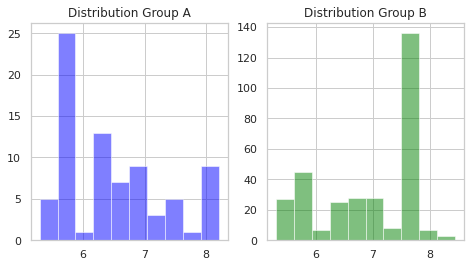

In [63]:
add_grafics(groups_add)